##### Copyright 2019 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

TODO:

- fix model creation (preprocessing breaks tensor? https://tensorflow.google.cn/tutorials/load_data/csv)

- name all layers

- save model for loading afterwards (currently broken, might require named layers, might clash with concatenate layer)

- make sure to mark unaltered cells and annotations as from the original tutorial

- make sure the GPU is used

- make model .fit and .evaluate work (if it does not)

- make callbacks work during fitting (in custom loop)


Maybe:

- make a preprocessing model where the preprocessing is done when SENN is initialized
(for portability)

- augment data by just adding random noise


# Classify structured data using Keras Preprocessing Layers

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/preprocessing_layers.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/preprocessing_layers.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/preprocessing_layers.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to classify structured data (e.g. tabular data in a CSV). You will use [Keras](https://www.tensorflow.org/guide/keras) to define the model, and [preprocessing layers](https://keras.io/guides/preprocessing_layers/) as a bridge to map from columns in a CSV to features used to train the model. This tutorial contains complete code to:

* Load a CSV file using [Pandas](https://pandas.pydata.org/).
* Build an input pipeline to batch and shuffle the rows using [tf.data](https://www.tensorflow.org/guide/datasets).
* Map from columns in the CSV to features used to train the model using Keras Preprocessing layers.
* Build, train, and evaluate a model using Keras.

Note: This tutorial is similar to [Classify structured data with feature columns](https://www.tensorflow.org/tutorials/structured_data/feature_columns). This version uses new experimental Keras [Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) instead of `tf.feature_column`. Keras Preprocessing Layers are more intuitive, and can be easily included inside your model to simplify deployment.

## The Dataset

For designing the network I use a smaller and simpler dataset. 

It is a simplified version of the PetFinder [dataset](https://www.kaggle.com/c/petfinder-adoption-prediction). There are several thousand rows in the CSV. Each row describes a pet, and each column describes an attribute. 

The goal is to predict if the pet will be adopted.

Following is a description of this dataset. \
Notice there are both numeric and categorical columns. 

The free text column will be ignored.

Column | Description| Feature Type | Data Type
------------|--------------------|----------------------|-----------------
Type | Type of animal (Dog, Cat) | Categorical | string
Age |  Age of the pet | Numerical | integer
Breed1 | Primary breed of the pet | Categorical | string
Color1 | Color 1 of pet | Categorical | string
Color2 | Color 2 of pet | Categorical | string
MaturitySize | Size at maturity | Categorical | string
FurLength | Fur length | Categorical | string
Vaccinated | Pet has been vaccinated | Categorical | string
Sterilized | Pet has been sterilized | Categorical | string
Health | Health Condition | Categorical | string
Fee | Adoption Fee | Numerical | integer
Description | Profile write-up for this pet | Text | string
PhotoAmt | Total uploaded photos for this pet | Numerical | integer
AdoptionSpeed | Speed of adoption | Classification | integer

## Install and Import necessary libraries


In [2]:
!pip install sklearn
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install pydot
!pip install pydotplus
!pip install graphviz
!pip install datetime
!pip install packaging
!pip install keras

Install for graph: https://graphviz.gitlab.io/download/
maybe follow: https://bobswift.atlassian.net/wiki/spaces/GVIZ/pages/131924165/Graphviz+installation

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing
from datetime import datetime
import tensorboard

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Reading in the data

The data is read into a pandas dataframe

Again:\
As the real data is sensitive, large and expensive to use,
for now I use a dummy dataset about adoption-speed

In [5]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

In [6]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


## Creating the target variable

I have to select the variable I want to train for and drop the columns that are not important or contain that information from the normal dataset.

Valid for the example data:
The task in the Kaggle competition was to predict the speed at which a pet will be adopted (e.g., in the first week, the first month, the first three months, and so on). Let's simplify this for our purposes. It is transformed into a binary classification problem:
I simply predict whether the pet was adopted, or not.

After modifying the label column, 0 will indicate the pet was not adopted, and 1 will indicate it was.

In [7]:
# In the original dataset "4" indicates the pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop un-used columns. (including our now target which can not be used for training)
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

In [8]:
#dataframe = dataframe.drop(columns=['Fee', 'PhotoAmt','Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
#                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1'])

#for testing

In [9]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1


## Spliting the dataframe into train, validation, and test

The loaded dataset was a single file. It has to be split into train, validation, and test sets.

In [10]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

7383 train examples
1846 validation examples
2308 test examples


## Input pipeline

The dataframe is wrapped with [tf.data](https://www.tensorflow.org/guide/datasets).
This is done to easily shuffle and batch the data. 

If the RAM is not sufficient, tf.data could be used directly to read it from disk in batches.

In [11]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=1):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

The general pipeline for input is finished here.
What does it look like?

In [12]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [13]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

# TODO currently this is targeted towards the dummy -set

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([ 4 50 24 17  3], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([0 0 1 1 0], shape=(5,), dtype=int32)


The dataset returns a dictionary of column names (from the dataframe) that map to column values from rows in the dataframe.

## Preprocessing layers

I will have to adapt the pipelines when I replace the dummy-code, but afterwards I will be able to input plain string data etc from new data as well.

Information about the pre-processing layers for easy access when I am there:

*   [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) - Feature-wise normalization of the data.
*   [`CategoryEncoding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/CategoryEncoding) - Category encoding layer.
*   [`StringLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/StringLookup) - Maps strings from a vocabulary to integer indices.
*   [`IntegerLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/IntegerLookup) - Maps integers from a vocabulary to integer indices.

A list of available preprocessing layers can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing).

### Numeric columns
A Normalization() layer ensures that each numeric feature has a mean of 0 and a standard deviation of 1.

The `get_normalization_layer` function returns a keras layer.
It applies featurewise normalization to numerical features.

In [14]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [15]:
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(photo_count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.50468034],
       [ 0.14564772],
       [-0.17951629],
       [-0.50468034],
       [-0.17951629]], dtype=float32)>

TODO: If I will indeed have many numeric features (hundreds, or more), it would be more efficient to concatenate them first and use a single [normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer.

### Categorical columns

In the dummy dataset, Type is represented as a string (e.g. 'Dog', or 'Cat'). Sadly, one can not feed strings directly to a model. The preprocessing layer takes care of representing strings as a one-hot vector.

The `get_category_encoding_layer` function returns a layer, mapping values from a vocabulary to integer indices and one-hot encodes the features.

In [16]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_values=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

  # Prepare a Dataset that only yields our feature.
  feature_ds = feature_ds.map(index)

  # Learn the space of possible indices.
  encoder.adapt(feature_ds)

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [17]:
type_col = train_features['Type']
layer = get_category_encoding_layer('Type', train_ds, 'string')
layer(type_col)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

Often, you don't want to feed a number directly into the model, but instead use a one-hot encoding of those inputs. Consider raw data that represents a pet's age.

In [18]:
type_col = train_features['Age']
category_encoding_layer = get_category_encoding_layer('Age', train_ds,
                                                      'int64', 5)
category_encoding_layer(type_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)>

## Choosing and preparing columns to use

While we can deal with all types of data, we have to make a list of all columns for each type.\
That way I am able to define which layer needs to be treated how\

In [19]:
batch_size = 1
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [20]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in ['PhotoAmt', 'Fee']:  # TODO use all headers in UMC set minus the ones I know are something else
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [21]:
# Categorical features encoded as integers.

# TODO at the UMC data, this will be more common, some tests have a categorical scale 
# However, most of them can just be interpreted as normal numerical feature, so I won't have to overdo it
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')
encoding_layer = get_category_encoding_layer('Age', train_ds, dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [22]:
# Categorical features encoded as string.
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1'] 
# TODO replace this by reading the headings from the dataframe and substracting the hardcoded headings (that I know are something else))

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=5) # TODO maybe, this line has to be duplicated and slightly changed to accomodate for different max_tokens
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


In [23]:
# Currently I do not think the UMC data needs to be balanced.
# It will be evaluated on the same dataset (though a different part of it)
# We do not have a large number of samples that are underrepresented, probably causing large inaccura

#use:
#    https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

## The model


In [24]:
# The first step towards a working model
# is our preprocessed input.
# As that is a relative complex task, that is regarded it's owy model.

preprocessed_layers = layers.Concatenate()(encoded_features) #encoded_features
preprocesessing_model = tf.keras.Model(all_inputs, preprocessed_layers)
preprocesessing_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Age (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
Type (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Color1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Color2 (InputLayer)             [(None, 1)]          0                                            
_______________________________________________________________________________________

Within the models structure, there are repetetive patterns.

For readability those layers are combined into custom layers and models:

In [25]:
# A combination of layers, common in the parameterizer

class ParameterizerLayer(layers.Layer):
    
    def __init__(self, out_shape, dropout_rate):
        super(ParameterizerLayer, self).__init__()
        self.para_lin = layers.Dense(out_shape, activation='linear')
        self.para_drop = layers.Dropout(dropout_rate)
        self.para_relu = layers.Dense(out_shape, activation=tf.keras.layers.LeakyReLU(alpha=0.05))
        
    
    def call(self, input_tensor,  training=False):
        x = self.para_lin(input_tensor)
        if training:
            x = self.para_drop(x, training=training)
        x = self.para_relu(x)        
        return x
    
# should minimize robustness loss

In [139]:
#functional model def

#TODO no more static sizes
batch_size = 1
preprocessed_inputs_shape = 55 
dropout_rate=0.1
hidden_sizes = [40, 20, 15, 5]  # TODO fix this to actual size
out_shape = preprocessed_inputs_shape

input_shape = [batch_size, preprocessed_inputs_shape]
input_layer = layers.Input(batch_shape = input_shape)

x = input_layer
###Parameterizer###
x = ParameterizerLayer(hidden_sizes[0], dropout_rate)(x)
x = ParameterizerLayer(hidden_sizes[1], dropout_rate)(x)
x = ParameterizerLayer(hidden_sizes[2], dropout_rate)(x)
x = ParameterizerLayer(hidden_sizes[3], dropout_rate)(x)
x = layers.Dense(out_shape, activation='linear')(x)
relevances = layers.Dropout(rate=dropout_rate, name="relevances")(x)

###Conceptizer###
concepts = layers.Lambda(lambda t: t, name="concepts")(input_layer)

###Aggregator###

aggregated = layers.multiply([relevances, concepts])
aggregated = layers.Lambda(lambda t: tf.keras.backend.sum(t, axis=-1))(aggregated)
aggregated = layers.Lambda(lambda t: tf.keras.activations.sigmoid(t), name="output")(aggregated)

out_layer = [aggregated, concepts, relevances]

functional_model = tf.keras.Model(inputs=input_layer, outputs=out_layer)

In [140]:
#custom fun with more inputs

def get_custom_loss(some_other_argument):
    
    def custom_loss(y_true, y_pred): 
        loss = 0
        loss = loss + some_other_argument
        loss = keras.losses.binary_crossentropy(y_true, y_pred)
        return loss
    
    return custom_loss

In [141]:
def zero_loss(y_true, y_pred):
    return 0

In [273]:
loss_dict = {
    "relevances": keras.losses.mean_absolute_error, #get_custom_loss(some_other_argument=1),
    "output": keras.losses.binary_crossentropy, #tf.nn.log_poisson_loss,
    "concepts": zero_loss
}

functional_model.compile(
    optimizer="adam", 
    loss=loss_dict,
    loss_weights=[1, 5, 0],
    metrics= ['accuracy']
)  
functional_model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(1, 55)]            0                                            
__________________________________________________________________________________________________
parameterizer_layer_28 (Paramet (1, 40)              3880        input_8[0][0]                    
__________________________________________________________________________________________________
parameterizer_layer_29 (Paramet (1, 20)              1240        parameterizer_layer_28[0][0]     
__________________________________________________________________________________________________
parameterizer_layer_30 (Paramet (1, 15)              555         parameterizer_layer_29[0][0]     
______________________________________________________________________________________

In [274]:
# do pre-processing of data separately
processed_train_ds = train_ds.map(
  lambda x, y: (
      tf.cast(preprocesessing_model(x), dtype=tf.float32), 
      tf.cast(y, dtype=tf.float32)
  )
)

In [275]:
# Define the Keras TensorBoard callback, used for the animated, interactive tensorboard visualizatioon
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

#This should plot the exhaustive graph, but is a bit unreliable
tf.keras.utils.plot_model(functional_model, show_shapes=True, rankdir="LR")

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [276]:
#tf.print("processed_train_ds shape:", processed_train_ds.take(0))
functional_model.fit(processed_train_ds, epochs=10, callbacks=tensorboard_callback)

Epoch 1/10
7383/7383 [==============================] - 8s 1ms/step - loss: 0.5111 - output_loss: 0.5111 - concepts_loss: 0.0000e+00 - relevances_loss: 0.5822 - output_accuracy: 0.7516 - concepts_accuracy: 0.0642 - relevances_accuracy: 0.0000e+00
Epoch 2/10
7383/7383 [==============================] - 7s 965us/step - loss: 0.5003 - output_loss: 0.5003 - concepts_loss: 0.0000e+00 - relevances_loss: 0.5669 - output_accuracy: 0.7548 - concepts_accuracy: 0.0642 - relevances_accuracy: 1.3545e-04
Epoch 3/10
7383/7383 [==============================] - 6s 877us/step - loss: 0.5016 - output_loss: 0.5016 - concepts_loss: 0.0000e+00 - relevances_loss: 0.5817 - output_accuracy: 0.7576 - concepts_accuracy: 0.0642 - relevances_accuracy: 0.0000e+00
Epoch 4/10
7383/7383 [==============================] - 6s 823us/step - loss: 0.5047 - output_loss: 0.5047 - concepts_loss: 0.0000e+00 - relevances_loss: 0.5729 - output_accuracy: 0.7535 - concepts_accuracy: 0.0642 - relevances_accuracy: 0.0000e+00
Epoch 

Questions:\
1: The error refers to this:\
I provide a gradient for every input feature (55),\
    that makes sense as my parameterizer has output-dimensions of one per input.\
However, it wants a second dimension of 10,\
    which is de dimension of the FIRST layer of the parameterizer, NOT the last.\
I do not understand that or what to do about it.\
\
2: How can I constrain the output to something from 0 to 1 without disconnecting the graph?\
3: Why are there only 18 trainable weights when the model has 55 preprocessed inputs\
   and the parameterizer has more than 18 outputs?\
4: How do I scale up to a larger batch_size, given that now I have to use the [0] trick to make it work?\
5: Why is the classification loss so weird sometimes target = predicted should give 0, right?

Let's visualize our connectivity graph:


### Test the model


In [302]:
# do pre-processing of data separately
processed_test_ds = test_ds.map(
  lambda x, y: (
      tf.cast(preprocesessing_model(x), dtype=tf.float32), 
      tf.cast(y, dtype=tf.float32)
  )
)

In [303]:
accuracy = functional_model.evaluate(processed_test_ds)
print("Accuracy", accuracy)

2308/2308 [==============================] - 1s 534us/step - loss: 0.5043 - output_loss: 0.5043 - concepts_loss: 0.0000e+00 - relevances_loss: 0.5528 - output_accuracy: 0.7595 - concepts_accuracy: 0.0602 - relevances_accuracy: 0.0000e+00
Accuracy [0.5042999386787415, 0.5042999386787415, 0.0, 0.5528015494346619, 0.7595320343971252, 0.06022530421614647, 0.0]


In [364]:
#divide x and y of test set
x = []
y_true = []

for x_var, y_var in processed_test_ds:
    x.append(x_var)
    y_true.append(y_var[0])

In [365]:
#### coursera util.py for metrics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)


def get_true_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def get_true_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def get_false_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def get_false_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))


def get_performance_metrics(y, pred, class_labels, tp=get_true_pos,
                            tn=get_true_neg, fp=get_false_pos,
                            fn=get_false_neg,
                            acc=None, prevalence=None, spec=None,
                            sens=None, ppv=None, npv=None, auc=None, f1=None,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round(tp(y[:, i], pred[:, i]),
                             3) if tp != None else "Not Defined"
        df.loc[i][2] = round(tn(y[:, i], pred[:, i]),
                             3) if tn != None else "Not Defined"
        df.loc[i][3] = round(fp(y[:, i], pred[:, i]),
                             3) if fp != None else "Not Defined"
        df.loc[i][4] = round(fn(y[:, i], pred[:, i]),
                             3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]),
                              3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df


def print_confidence_intervals(class_labels, statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    for i in range(len(class_labels)):
        mean = statistics.mean(axis=1)[i]
        max_ = np.quantile(statistics, .95, axis=1)[i]
        min_ = np.quantile(statistics, .05, axis=1)[i]
        df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df


def get_curve(gt, pred, target_names, curve='roc'):
    for i in range(len(target_names)):
        if curve == 'roc':
            curve_function = roc_curve
            auc_roc = roc_auc_score(gt[:, i], pred[:, i])
            label = target_names[i] + " AUC: %.3f " % auc_roc
            xlabel = "False positive rate"
            ylabel = "True positive rate"
            a, b, _ = curve_function(gt[:, i], pred[:, i])
            plt.figure(1, figsize=(7, 7))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(a, b, label=label)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        elif curve == 'prc':
            precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
            average_precision = average_precision_score(gt[:, i], pred[:, i])
            label = target_names[i] + " Avg.: %.3f " % average_precision
            plt.figure(1, figsize=(7, 7))
            plt.step(recall, precision, where='post', label=label)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)


In [382]:
from sklearn.metrics import roc_curve

y_pred = functional_model.predict(x)[0]
### binarize the classifications
threshold = 0.5
y_pred_binary = np.where(y_pred > threshold, 1, 0)
tf.print("y_pred_binary:", y_pred_binary)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y, y_pred_binary)

[array([0.83355117], dtype=float32),
 array([[-0.17951629, -0.29800498,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32),
 array([[ 0.16350377, -0.14218885,  0.84711605, -0.2071761 ,  0.365334  ,
         0.21852273,  0.822676  ,  0.954883  ,  0.9507357 ,  

TypeError: '>' not supported between instances of 'list' and 'float'

In [374]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
class_labels = ['not adopted', 'adopted']
get_curve(y, y_pred, class_labels, curve='roc')

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ROC'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [377]:
functional_model.summary()

InvalidArgumentError: Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: strided_slice/

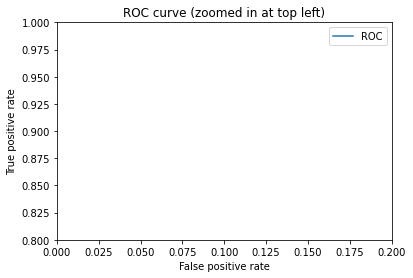

In [375]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ROC'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [279]:
functional_model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(1, 55)]            0                                            
__________________________________________________________________________________________________
parameterizer_layer_28 (Paramet (1, 40)              3880        input_8[0][0]                    
__________________________________________________________________________________________________
parameterizer_layer_29 (Paramet (1, 20)              1240        parameterizer_layer_28[0][0]     
__________________________________________________________________________________________________
parameterizer_layer_30 (Paramet (1, 15)              555         parameterizer_layer_29[0][0]     
______________________________________________________________________________________

In [280]:
#visualize model in an interactive way
#sadly only works until the preprocessing layers are over
# tensorboard sometimes thinks there still is an instance running when it is not
# fix that by deleting the contents of this folder or your equivalent of it
# C:\Users\deisl\AppData\Local\Temp\.tensorboard-info

%reload_ext tensorboard
# rankdir='LR' is used to make the graph horizontal.
#tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 9256), started 15:16:25 ago. (Use '!kill 9256' to kill it.)

## Inference on new data

As the model contains all important parts, it should be able to work on any file of the right format


The model should be saved such that it can just be reloaded later.\
I will follow the tutorial [here](https://www.tensorflow.org/tutorials/keras/save_and_load)

In [281]:
functional_model.save('my_pet_classifier')
reloaded_model = tf.keras.models.load_model('my_pet_classifier')

INFO:tensorflow:Assets written to: my_pet_classifier\assets


ValueError: Unknown loss function: zero_loss

To get a prediction for a new sample, you can simply call `model.predict()`. There are just two things you need to do:

1.   Wrap scalars into a list so as to have a batch dimension (models only process batches of data, not single samples)
2.   Call `convert_to_tensor` on each feature

In [284]:
# TODO this does not work

sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}

prediction_example = preprocesessing_model(sample)


predictions = functional_model.predict(prediction_example)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

AttributeError: 'str' object has no attribute '_keras_mask'

Old code for reference: